# Keras-OCR and model deployment

This is an adaptation of the notebook documented [here](https://keras-ocr.readthedocs.io/en/latest/examples/end_to_end_training.html).
I adapted some parts (compiling in eagerly mode, fonts variable) and deployed the model in Sagemaker


# Prerequisites

First, we install keras-ocr from github and openCV

In [70]:
!pip install -U git+https://github.com/faustomorales/keras-ocr.git#egg=keras-ocr
!pip install -U opencv-python # We need the most recent version of OpenCV.
%tensorflow_version 2.x

  Cloning https://github.com/faustomorales/keras-ocr.git to /tmp/pip-install-isxrc8li/keras-ocr_8b9e1e25f5804dd186c1f904eeaf12ee
  Running command git clone --filter=blob:none --quiet https://github.com/faustomorales/keras-ocr.git /tmp/pip-install-isxrc8li/keras-ocr_8b9e1e25f5804dd186c1f904eeaf12ee
  Resolved https://github.com/faustomorales/keras-ocr.git to commit e8d34a46f07d50158e1d86d6c617e99bfe99e2f8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


UsageError: Line magic function `%tensorflow_version` not found.


Optionally, you can also install keras-ocr from Pypi

In [ ]:
# To install from PyPi
!pip install keras-ocr

# Synthetic data generation
Define the following imports and configure the data directory and alphabet (letters, numbers and punctuation) to generate synthetic data.
Keras-ocr includes a set of fonts and backgrounds which have been downloaded from Google Fonts and Wikimedia. The code to generate both of these sets is available in the repository under scripts/create_fonts_and_backgrounds.py.

The fonts cover different languages which may have non-overlapping characters. keras-ocr supplies a function (font_supports_alphabet) to verify that a font includes the characters in an alphabet. We filter to only these fonts. We also exclude any fonts that are marked as thin in the filename because those tend to be difficult to render in a legible manner.

The backgrounds folder contains about just over 1,000 image backgrounds.

In [71]:
import zipfile
import datetime
import string
import math
import os

import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn.model_selection

import keras_ocr



data_dir = '.'
alphabet = string.digits + string.ascii_letters + '!?. '
recognizer_alphabet = ''.join(sorted(set(alphabet.lower())))

backgrounds = keras_ocr.data_generation.get_backgrounds(cache_dir=data_dir)

Looking for ./backgrounds.zip


Now, we define the fonts we want to use

In [76]:
fonts = ['./fonts/nanumpenscript/NanumPenScript-Regular.ttf',
 './fonts/tauri/Tauri-Regular.ttf',
 './fonts/vibur/Vibur-Regular.ttf',
 './fonts/rasa/Rasa-SemiBold.ttf',
 './fonts/rasa/Rasa-Regular.ttf',
 './fonts/rasa/Rasa-Medium.ttf',
 './fonts/rasa/Rasa-Light.ttf',
 './fonts/rasa/Rasa-Bold.ttf',
 './fonts/questrial/Questrial-Regular.ttf',
 './fonts/basic/Basic-Regular.ttf',
 './fonts/overpassmono/OverpassMono-Bold.ttf',
 './fonts/overpassmono/OverpassMono-SemiBold.ttf',
 './fonts/overpassmono/OverpassMono-Regular.ttf',
 './fonts/overpassmono/OverpassMono-Light.ttf',
 './fonts/tharlon/Tharlon-Regular.ttf',
 './fonts/amita/Amita-Bold.ttf',
 './fonts/amita/Amita-Regular.ttf',
 './fonts/marcellus/Marcellus-Regular.ttf',
 './fonts/andika/Andika-Regular.ttf',
 './fonts/baloochettan/BalooChettan-Regular.ttf',
 './fonts/firamono/FiraMono-Medium.ttf',
 './fonts/firamono/FiraMono-Bold.ttf',
 './fonts/firamono/FiraMono-Regular.ttf',
 './fonts/sedansc/SedanSC-Regular.ttf',
 './fonts/pontanosans/PontanoSans-Regular.ttf',
 './fonts/mansalva/Mansalva-Regular.ttf',
 './fonts/novaflat/NovaFlat.ttf']

The first generated text is: Athletes the knowledge to the Pastry War in 1982. Denmark has greatly
The first generated validation image (below) contains: T
he decline
few secon
ds durati
on a person


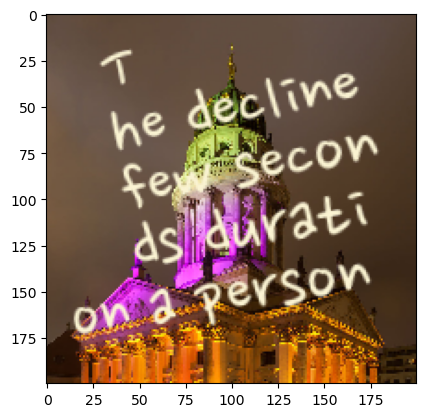

In [77]:
text_generator = keras_ocr.data_generation.get_text_generator(alphabet=alphabet)
print('The first generated text is:', next(text_generator))

def get_train_val_test_split(arr):
    train, valtest = sklearn.model_selection.train_test_split(arr, train_size=0.8, random_state=42)
    val, test = sklearn.model_selection.train_test_split(valtest, train_size=0.5, random_state=42)
    return train, val, test

background_splits = get_train_val_test_split(backgrounds)
font_splits = get_train_val_test_split(fonts)

image_generators = [
    keras_ocr.data_generation.get_image_generator(
        #you can play around with this size to adjust the image size
        height=200,
        width=200,
        text_generator=text_generator,
        font_groups={
            alphabet: current_fonts
        },
        backgrounds=current_backgrounds,
        font_size=(30, 60), #you can play around with the font-size
        margin=10,
        rotationX=(-0.05, 0.05),
        rotationY=(-0.05, 0.05),
        rotationZ=(-15, 15)
    )  for current_fonts, current_backgrounds in zip(
        font_splits,
        background_splits
    )
]

# See what the first validation image looks like.
image, lines = next(image_generators[1])
text = keras_ocr.data_generation.convert_lines_to_paragraph(lines)
print('The first generated validation image (below) contains:', text)
plt.imshow(image)

The model contains two parts: The detector and the recognizer. The detector uses the CRAFT architecture to detect text area. The recognizer uses the CRNN architecture to detect the text.

The Clove AI has pretained some models and we will be using their weights. You can find out more information about Clove Ai [here](https://github.com/clovaai/deep-text-recognition-benchmark).

In [ ]:
detector = keras_ocr.detection.Detector(weights='clovaai_general')
recognizer = keras_ocr.recognition.Recognizer(
    alphabet=recognizer_alphabet,
    weights='kurapan'
)
recognizer.compile(run_eagerly=True)#add this line to run in eagerly mode
for layer in recognizer.backbone.layers:
    layer.trainable = False

This image contains: L


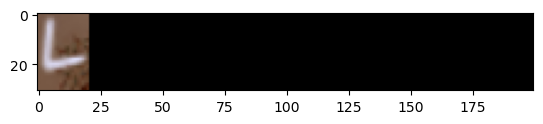

In [79]:
max_length = 5
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [13]:
detector_batch_size = 15
detector_basepath = os.path.join(data_dir, f'detector_{datetime.datetime.now().isoformat()}')
detection_train_generator, detection_val_generator, detection_test_generator = [
    detector.get_batch_generator(
        image_generator=image_generator,
        batch_size=detector_batch_size
    ) for image_generator in image_generators
]
detector.model.fit(
    detection_train_generator,
    steps_per_epoch=math.ceil(len(background_splits[0]) / detector_batch_size),
    epochs=5,
    workers=0,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=5),
        tf.keras.callbacks.CSVLogger(f'{detector_basepath}.csv'),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{detector_basepath}.h5')
    ],
    validation_data=detection_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / detector_batch_size),
    batch_size=detector_batch_size
)

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras_ocr/tools.py:580: RuntimeWarning: invalid value encountered in scalar divide
  rotation = np.arctan((tl[0] - bl[0]) / (tl[1] - bl[1]))


Epoch 1/5


2024-05-08 14:07:23.187604: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-08 14:07:57.283889: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5f3c8a0260 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 14:07:57.283927: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 14:07:57.283937: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 14:07:57.283943: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 14:07:57.283949: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 14:07:57.453966: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.

56/56 [==============================] - ETA: 0s - loss: 0.0067

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


56/56 [==============================] - 171s 2s/step - loss: 0.0067 - val_loss: 0.0059
Epoch 2/5
56/56 [==============================] - 103s 2s/step - loss: 0.0024 - val_loss: 0.0047
Epoch 3/5
56/56 [==============================] - 106s 2s/step - loss: 0.0021 - val_loss: 0.0044
Epoch 4/5
56/56 [==============================] - 99s 2s/step - loss: 0.0020 - val_loss: 0.0046
Epoch 5/5
56/56 [==============================] - 98s 2s/step - loss: 0.0016 - val_loss: 0.0046


This image contains: M


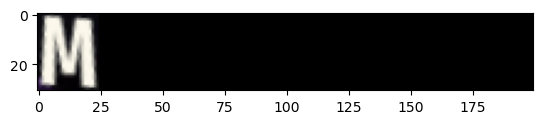

In [80]:
max_length = 10
recognition_image_generators = [
    keras_ocr.data_generation.convert_image_generator_to_recognizer_input(
        image_generator=image_generator,
        max_string_length=min(recognizer.training_model.input_shape[1][1], max_length),
        target_width=recognizer.model.input_shape[2],
        target_height=recognizer.model.input_shape[1],
        margin=1
    ) for image_generator in image_generators
]

# See what the first validation image for recognition training looks like.
image, text = next(recognition_image_generators[1])
print('This image contains:', text)
plt.imshow(image)

In [12]:
import tensorflow as tf
import tensorflow.compat.v1 as tf 

recognition_batch_size = 8
recognizer_basepath = os.path.join(data_dir, f'recognizer_{datetime.datetime.now().isoformat()}')
recognition_train_generator, recognition_val_generator, recogntion_test_generator = [
    recognizer.get_batch_generator(
      image_generator=image_generator,
      batch_size=recognition_batch_size,
      lowercase=True
    ) for image_generator in recognition_image_generators
]
#train the recognizer model
recognizer.training_model.fit(
    recognition_train_generator,
    epochs=5,
    verbose = 1,
    steps_per_epoch=math.ceil(len(background_splits[0]) / recognition_batch_size),
    callbacks=[
        tf.keras.callbacks.EarlyStopping(restore_best_weights=True, patience=25),
        tf.keras.callbacks.CSVLogger(f'{recognizer_basepath}.csv', append=True),
        tf.keras.callbacks.ModelCheckpoint(filepath=f'{recognizer_basepath}.h5')
    ],
    validation_data=recognition_val_generator,
    validation_steps=math.ceil(len(background_splits[1]) / recognition_batch_size),
    workers=0,
    #batch_size = recognition_batch_size
)

Epoch 1/5


2024-05-08 17:02:25.874694: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-08 17:02:42.871924: I external/local_xla/xla/service/service.cc:168] XLA service 0x55971f8b9900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-08 17:02:42.871965: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 17:02:42.871976: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 17:02:42.871983: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 17:02:42.871988: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
2024-05-08 17:02:42.879490: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.

104/104 [==============================] - 58s 360ms/step - loss: 16.4006 - val_loss: 9.7489
Epoch 2/5


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


104/104 [==============================] - 33s 316ms/step - loss: 4.8707 - val_loss: 6.2031
Epoch 3/5
104/104 [==============================] - 32s 309ms/step - loss: 3.7304 - val_loss: 3.7738
Epoch 4/5
104/104 [==============================] - 32s 306ms/step - loss: 3.1755 - val_loss: 3.9306
Epoch 5/5
104/104 [==============================] - 32s 312ms/step - loss: 2.6827 - val_loss: 4.7443


As explained in the documentation, we can create a pipeline with the recognizer and detector to look and detect text in an image

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-05-09 10:45:12.133042: W tensorflow/c/c_api.cc:305] Operation '{name:'conv_cls.8/BiasAdd' id:1786 op device:{requested: '', assigned: ''} def:{{{node conv_cls.8/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_format="NHWC"](conv_cls.8/Conv2D, conv_cls.8/BiasAdd/ReadVariableOp)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-05-09 10:45:13.923573: W tensorflow/c/c_api.cc:305] Operation '{name:'decode/PadV2' id:4302 op device:{requested: '', assigned: ''} def:{{{node decode/PadV2}} = Pa

Actual: F
o r e n s i c   t e s t i
m o n y   c o m
b i n e d   r e a c
h i n g   a   g l o b Predicted: ['o8w 84m8?84848m', 'om8m8m2.4 z0..0.48', 'o8m84m81i1.?.4.4848', 'o8m2m4.k48', 'm2367mz4848', 'o8zjt?4 080.m474m8m', 'o8q41alzmxmzm4m4m', '8m0.2m 8m4m74m8m', 'o48n g z 48m', '8 ?t1h0zr4m']


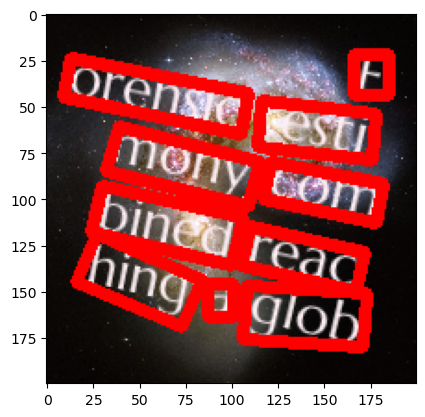

In [81]:
pipeline = keras_ocr.pipeline.Pipeline(detector=detector, recognizer=recognizer)
image, lines = next(image_generators[0])
predictions = pipeline.recognize(images=[image])[0]
drawn = keras_ocr.tools.drawBoxes(
    image=image, boxes=predictions, boxes_format='predictions'
)
print(
    'Actual:', '\n'.join([' '.join([character for _, character in line]) for line in lines]),
    'Predicted:', [text for text, box in predictions]
)
plt.imshow(drawn)

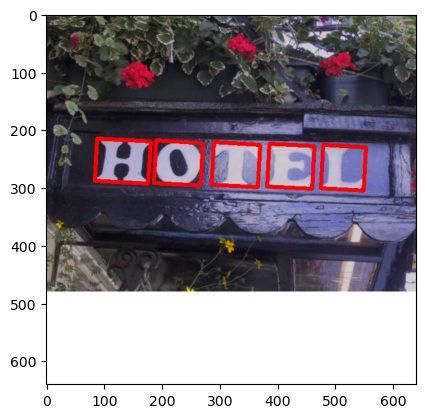

In [17]:
image, lines, confidence = next(training_image_generator)
canvas = keras_ocr.tools.drawBoxes(image=image, boxes=lines, boxes_format='lines')
plt.imshow(canvas)

Now, we can load the weights of the recognizer and detector after they are done training

In [20]:
detector.model.load_weights(os.path.join(data_dir, 'detector_2024-05-08T14:07:13.153730.h5'))

In [21]:
recognizer.model.load_weights('recognizer_2024-05-08T17:02:24.972771.h5')

# Model deployment in Sagemaker

We will use the protobuf format to deploy the recognizer model. You should get a .pb result at end. This represents the model saved in protobuf

In [44]:
from tensorflow.python.saved_model import builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
tf.compat.v1.disable_eager_execution()
from keras import backend as K
import tensorflow.python.keras.backend as K

# Note: This directory structure will need to be followed 
model_version = '1'
export_dir = 'export/Servo/' + model_version

# Build the Protocol Buffer SavedModel at path defined by export_dir variable
builder = builder.SavedModelBuilder(export_dir)

# Create prediction signature to be used by TensorFlow Serving Predict API
#we will be deploying the recognizer
signature = predict_signature_def(
    inputs={"inputs": recognizer.model.input}, outputs={"score": recognizer.model.output})

# Save the meta graph and variables
builder.add_meta_graph_and_variables(
    sess=K.get_session(), tags=[tag_constants.SERVING], signature_def_map={"serving_default": signature})
builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: export/Servo/1/saved_model.pb


2024-05-08 17:39:49.986479: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 17:39:49.986904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-08 17:39:49.987276: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

b'export/Servo/1/saved_model.pb'

In [49]:
import tarfile
model_archive = 'model.tar.gz'
with tarfile.open(model_archive, mode='w:gz') as archive:
    archive.add('export', recursive=True) 

# upload model artifacts to S3
model_data = sess.upload_data(path=model_archive, key_prefix='model')


In [ ]:
#run only if train.py doesn't exist
!touch train.py

In [85]:
#we build a Tensorflow model object
import sagemaker
sagemaker_session = sagemaker.Session()
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '2.14',
                                  entry_point = 'train.py')

In [86]:
#we deploy it
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge')

---------!